# Lab 1 Task 1

## 1. Implement the following layers as Python functions (both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

In [1]:
import os
from typing import Callable, Iterable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
class Parameter:
    def __init__(self, data: np.ndarray) -> None:
        self.data = data
        self.grad = None


class Module:
    def __call__(self, *args, **kwargs) -> np.ndarray:
        return self.forward(*args, **kwargs)

    def __repr__(self) -> str:
        layers = '\n'.join([f'  ({k}): {v}' for k, v in self.__dict__.items()])
        return f'{self.__class__.__name__}(\n{layers}\n)'

In [3]:
class Linear(Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize weights and biases
        init_factor = 0.01
        self.W = Parameter(np.random.randn(in_features, out_features) * init_factor)
        self.b = Parameter(np.zeros((1, out_features)))

        # Cache for backward pass
        self.x = None

    def forward(self, x):
        # 學生實作部分：return output of linear layer
        self.x = x
        out = x @ self.W.data + self.b.data
        return out

    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input and compute gradients for weights and biases
        dx = dy @ self.W.data.T
        self.W.grad = self.x.T @ dy
        self.b.grad = np.sum(dy, axis=0, keepdims=True)
        return dx

    def parameters(self):
        return self.W, self.b

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(in_features={self.in_features}, out_features={self.out_features})'


class ReLU(Module):
    def __init__(self) -> None:
        super().__init__()
        self.x = None

    def forward(self, x):
        # 學生實作部分：return output of ReLU activation
        self.x = x
        return np.maximum(0, x)


    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input
        dx = dy * (self.x > 0)
        return dx


    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Sigmoid(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # 學生實作部分：return output of Sigmoid activation
        self.y = 1 / (1 + np.exp(-x))
        return self.y

    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input
        dx = dy * self.y * (1 - self.y)
        return dx

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Softmax(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # 學生實作部分：return output of Softmax activation
        shifted_x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(shifted_x)
        self.y = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.y


    def backward(self, dy):
        # 這邊我們設定同學們會將Softmax和Cross-Entropy Loss一起使用
        # 因此backward pass根據講義上的說明使用簡化的版本在Cross-Entropy Loss的部分完成
        # 若同學的softmax沒有和Cross-Entropy Loss一起使用，請自行實作完整的backward pass
        return dy

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [4]:
class MLP(Module):
    def __init__(self, in_features=784, hidden_features=128, num_classes=10) -> None:
        # 學生實作部分：design your Model architecture here
        # super().__init__()
        self.fc1 = Linear(in_features, hidden_features)
        self.relu = ReLU()
        self.fc2 = Linear(hidden_features, num_classes)
        self.softmax = Softmax()

    def forward(self, x):
        # 學生實作部分：compute forward pass through your model
        out = self.fc1.forward(x)
        out = self.relu.forward(out)
        out = self.fc2.forward(out)
        out = self.softmax.forward(out)
        return out

    def backward(self, dy):
        # 學生實作部分：compute backward pass through your model
        dy = self.fc2.backward(dy)
        dy = self.relu.backward(dy)
        dy = self.fc1.backward(dy)
        return dy

    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters()

## 2. Implement training and testing process
* included cross-validation

In [5]:
class MNIST:
    # root請根據你的檔案位置更改
    def __init__(self, root='./data', train=True, transform: Callable = None) -> None:
        path = os.path.join(root, 'mnist_train.csv' if train else 'mnist_test.csv')
        self.data = np.loadtxt(path, delimiter=',')
        self.transform = transform
        self.image_size = 28
        self.num_classes = 10
        self.classes = np.arange(self.num_classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = (self.data[idx, 0] == self.classes).astype(
            np.float32
        )  # one-hot encoding
        image = (
            self.data[idx, 1:]
            .reshape(self.image_size * self.image_size)
            .astype(np.float32)
        )
        if self.transform:
            image = self.transform(image)
        return image, label


class Subset:
    def __init__(self, dataset, indices: Iterable) -> None:
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


class DataLoader:
    def __init__(self, dataset, batch_size=1) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(dataset))

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        for start_idx in range(0, len(self.dataset), self.batch_size):
            end_idx = min(start_idx + self.batch_size, len(self.dataset))
            batch_indices = self.indices[start_idx:end_idx]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                image, label = self.dataset[idx]
                batch_images.append(image)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

In [6]:
# Separate train_imgs, train_labels into training and validation
# root請根據你的檔案位置更改
def load_mnist_data(
    root="./data", batch_size=1, split_ratio=0.1, transform=None
) -> tuple[DataLoader, DataLoader, DataLoader]:
    def _split_dataset(dataset, split_ratio):
        # 學生實作部分：split dataset into training and validation sets
        # hint: return Subset(dataset, train_indices), Subset(dataset, valid_indices)
        # 1. total length and index list
        dataset_size = len(dataset)
        indices = np.arange(dataset_size)

        # 2. shuffle
        np.random.shuffle(indices)

        # 3. calculate splitting point
        split = int(split_ratio * dataset_size)
        train_indices = indices[split:]
        valid_indices = indices[:split]
        return Subset(dataset, train_indices), Subset(dataset, valid_indices)
        
        

    trainset = MNIST(root=root, train=True, transform=transform)
    testset = MNIST(root=root, train=False, transform=transform)
    trainset, validset = _split_dataset(trainset, split_ratio=split_ratio)
    trainldr = DataLoader(trainset, batch_size=batch_size)
    validldr = DataLoader(validset, batch_size=batch_size)
    testldr = DataLoader(testset, batch_size=batch_size)
    return trainldr, validldr, testldr

In [7]:
class CrossEntropyLoss(Module):
    def __init__(self, epsilon=1e-15) -> None:
        super().__init__()
        self.epsilon = epsilon  # small value to avoid log(0)
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)
        self.y_true = y_true
        batch_size = y_true.shape[0]
        loss = -np.sum(y_true * np.log(self.y_pred)) / batch_size
        return loss

    def backward(self):
        batch_size = self.y_true.shape[0]
        grad = (self.y_pred - self.y_true) / batch_size
        return grad

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


class SGD:
    def __init__(self, params: Iterable, lr: float = 1e-3) -> None:
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.fill(0)

In [8]:
def train_one_epoch(model: Module, trainldr: Iterable, criterion, optimizer) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    for x, y in tqdm(trainldr):
        # 學生實作部分：complete the training process through one epoch
        # ========== 1. forward ==========
        out = model.forward(x)  # forward pass

        # ========== 2. compute loss ==========
        loss = criterion(out, y)
        total_loss += loss
        total += len(y)

        # ========== 3. compute accuracy ==========
        pred = np.argmax(out, axis=1)
        correct += np.sum(pred == y)

        # ========== 4. backward ==========
        dy = criterion.backward()     # dL/dy_pred
        model.backward(dy)

        # ========== 5. update ==========
        optimizer.step()
        optimizer.zero_grad()
        
        # Hint:
        # 1. forward propagation
        # 2. compute loss
        # 3. compute accuracy
        # 4. backward propagation
        # 5. update parameters
        
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model: Module, testldr: Iterable) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    criterion = CrossEntropyLoss()  # separate criterion from training
    for data, target in tqdm(testldr):
        # complete the evaluation process
        # ========== 1. forward ==========
        out = model.forward(data)

        # ========== 2. compute loss ==========
        loss = criterion(out, target)
        total_loss += float(loss)

        # ========== 3. compute accuracy ==========
        pred = np.argmax(out, axis=1)
        correct += np.sum(pred == target)
        total += len(target)
        # Hint:
        # 1. forward propagation
        # 2. compute total loss
        # 3. compute correct and total

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train(model: MLP, trainldr: Iterable, validldr: Iterable, epochs=10, lr=1e-3):
    criterion = CrossEntropyLoss()
    # 這邊提供SGD作為optimizer，同學也可以根據自己人需求更換其他optimizer
    optimizer = SGD(model.parameters(), lr=lr)
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, trainldr, criterion, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        print(f'epoch {epoch:d}: train_loss = {loss}, train_acc = {acc}')

        loss, acc = evaluate(model, validldr)
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(f'epoch {epoch:d}: valid_loss = {loss}, valid_acc = {acc}\n')

    return train_loss, train_acc, valid_loss, valid_acc

In [11]:
def transform(x):
    """map pixels information from range(0, 255) to range(0.01, 1)"""
    return np.asarray(x) * 0.99 + 0.01

# "../data"請根據你的檔案位置更改
trainldr, validldr, testldr = load_mnist_data(
    "./data", batch_size=1, transform=transform
)
print(f"train set: {len(trainldr)} images")
print(f"validation set: {len(validldr)} images")
print(f"test set: {len(testldr)} images")
for x, y in trainldr:
    print(f"x shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break

net = MLP()
print(net)
# 你可以調整 epochs 和 lr 來觀察不同的訓練效果
train_loss, train_acc, valid_loss, valid_acc = train(
    net, trainldr, validldr, epochs=10, lr=0.005
)

train set: 54000 images
validation set: 6000 images
test set: 10000 images
x shape: (1, 784)
y shape: (1, 10)
MLP(
  (fc1): Linear(in_features=784, out_features=128)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10)
  (softmax): Softmax()
)


100%|██████████| 54000/54000 [00:09<00:00, 5853.53it/s]


epoch 0: train_loss = 2.310126360797459, train_acc = 0.7880925925925926


100%|██████████| 6000/6000 [00:00<00:00, 42476.40it/s]


epoch 0: valid_loss = 2.3024319335866723, valid_acc = 0.00016666666666666666



100%|██████████| 54000/54000 [00:09<00:00, 5924.46it/s]


epoch 1: train_loss = 2.302277998554196, train_acc = 0.7985185185185185


100%|██████████| 6000/6000 [00:00<00:00, 42397.04it/s]


epoch 1: valid_loss = 2.3024341240442183, valid_acc = 0.00016666666666666666



100%|██████████| 54000/54000 [00:09<00:00, 5896.33it/s]


epoch 2: train_loss = 2.3022780705415085, train_acc = 0.7985185185185185


100%|██████████| 6000/6000 [00:00<00:00, 42362.43it/s]


epoch 2: valid_loss = 2.3024341240442183, valid_acc = 0.00016666666666666666



100%|██████████| 54000/54000 [00:09<00:00, 5893.58it/s]


epoch 3: train_loss = 2.3022780705415085, train_acc = 0.7985185185185185


100%|██████████| 6000/6000 [00:00<00:00, 42076.56it/s]


epoch 3: valid_loss = 2.3024341240442183, valid_acc = 0.00016666666666666666



100%|██████████| 54000/54000 [00:09<00:00, 5860.28it/s]


epoch 4: train_loss = 2.3022780705415085, train_acc = 0.7985185185185185


100%|██████████| 6000/6000 [00:00<00:00, 42391.40it/s]


epoch 4: valid_loss = 2.3024341240442183, valid_acc = 0.00016666666666666666



 35%|███▍      | 18651/54000 [00:03<00:06, 5742.02it/s]


KeyboardInterrupt: 

In [12]:
# Using test_images and test_labels to do the final test
test_loss, test_acc = evaluate(net, testldr)
print(f"test_loss = {test_loss}, test_acc = {test_acc}")

100%|██████████| 10000/10000 [00:00<00:00, 39249.10it/s]

test_loss = 2.301886809333283, test_acc = 1.0


## 3. Plot loss & accuracy curves(both Training and Validation)

NameError: name 'train_loss' is not defined

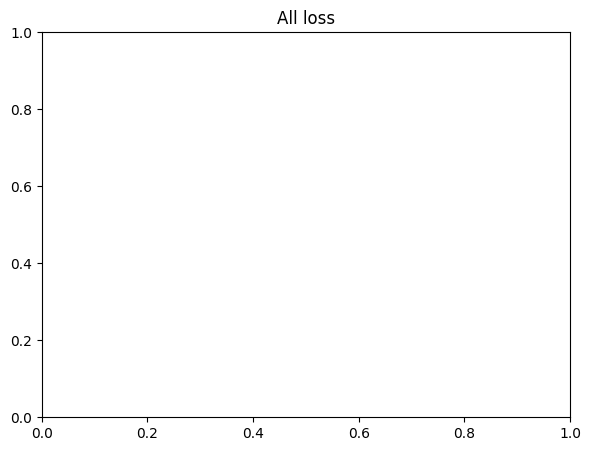

In [13]:
# Plot training and validation loss and accuracy curves
def plt_acc_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All acc')

    ax1.plot(train_acc)
    ax1.plot(valid_acc)

    ax1.legend(['train_acc', 'valid_acc'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

def plt_loss_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All loss')

    ax1.plot(train_loss)
    ax1.plot(valid_loss)

    ax1.legend(['train_loss', 'valid_loss'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()


plt_loss_all()
plt_acc_all()